In [1]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
import os
import random
import re

In [2]:
#load needed dataframes:
#Dataframe with information about character game appearances:
with open('df_meta.pickle', 'rb') as f:
    df_meta = pickle.load(f)
#Dataframe with character text:
with open('df_final.pickle', 'rb') as f:
    df_text = pickle.load(f)
#Directed graph of all characters
with open('DG.pickle', 'rb') as f:
    DG = pickle.load(f)

>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for characters in WC2X, and for WC3 respectively.

In [32]:
# names of WC2X characters
names_l = list(df_meta[df_meta.WC2X==1]['Name'])

# get tokens for these characters
l = []
for name in names_l:
    for token in df_text['Clean Text'].loc[df_text['Name'] == name].item().split():
        l.append(token)
        
len(l)

112003

In [31]:
# names of WC2X characters
names_l_ref = list(df_meta[df_meta.WC3==1]['Name'])

# get tokens for these characters
l_ref = []
for name in names_l_ref:
    for token in df_text['Clean Text'].loc[df_text['Name'] == name].item().split():
        l_ref.append(token)
        
len(l_ref)

226328

>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

In [35]:
from collections import Counter
p = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0], item[1]/len(l_ref)) for item in Counter(l_ref).items()])

>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?

In [36]:
all_tokens = set(p.keys()).union(set(p_ref.keys()))
delta_p = dict([(token, p.get(token,0) - p_ref.get(token,0)) for token in all_tokens])
# printing the top 10 tokens with largest relative frequency
print(sorted(delta_p.items(), key=lambda x:x[1], reverse=True)[:10])

[('Varian', 0.003242611833522856), ('his', 0.002659349181925879), ('Alleria', 0.0025411639298444804), ('Turalyon', 0.0022730391622989574), ('Khadgar', 0.002266217624203931), ('he', 0.0021634955692119897), ('Deathwing', 0.0014026641649301425), ('the', 0.0014022934265913722), ('Alliance', 0.0011923498439343706), ('Stormwind', 0.00117382511662621)]


>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - mean$, using the labMT dictionary. Here, we subtract the mean, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 

In [58]:
#Load LabMT word list as dataframe:
df_happy = pd.read_csv('Data_Set_S1.txt', skiprows=2, sep="\t")
df_happy_dict = df_happy.set_index("word")
df_happy_dict

,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
word,,,,,,,
laughter,1,8.50,0.9313,3600,--,--,1728
happiness,2,8.44,0.9723,1853,2458,--,1230
love,3,8.42,1.1082,25,317,328,23
happy,4,8.30,0.9949,65,1372,1313,375
laughed,5,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...
murder,10218,1.48,1.0150,2762,3110,1541,1059
terrorism,10219,1.48,0.9089,--,--,3192,--
rape,10220,1.44,0.7866,3133,--,4115,2977


In [61]:
# compute happiness
import numpy as np
h = dict([(token, df_happy_dict['happiness_average'].get(token, np.nan)-df_happy['happiness_average'].mean()) for token in all_tokens])

In [ ]:
# compute delta phi
d_phi = dict([(token, h[token]*delta_p[token]) for token in all_tokens if not np.isnan(h[token])])

In [68]:
# print top 10 tokens ordered by |d_phi|
sorted(d_phi.items(), key=lambda x:abs(x[1]), reverse=True)[:10]

[('she', -0.002066626990447301),
 ('her', -0.001643811899915811),
 ('night', -0.001042535406584029),
 ('fight', -0.0008243571422544408),
 ('demon', 0.0006902332949060215),
 ('not', -0.000588888209897627),
 ('war', -0.0005606677807765777),
 ('the', -0.0005542420039628486),
 ('death', 0.0005445291543461061),
 ('his', 0.000491342208175506)]

C:\Users\Yucheng\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


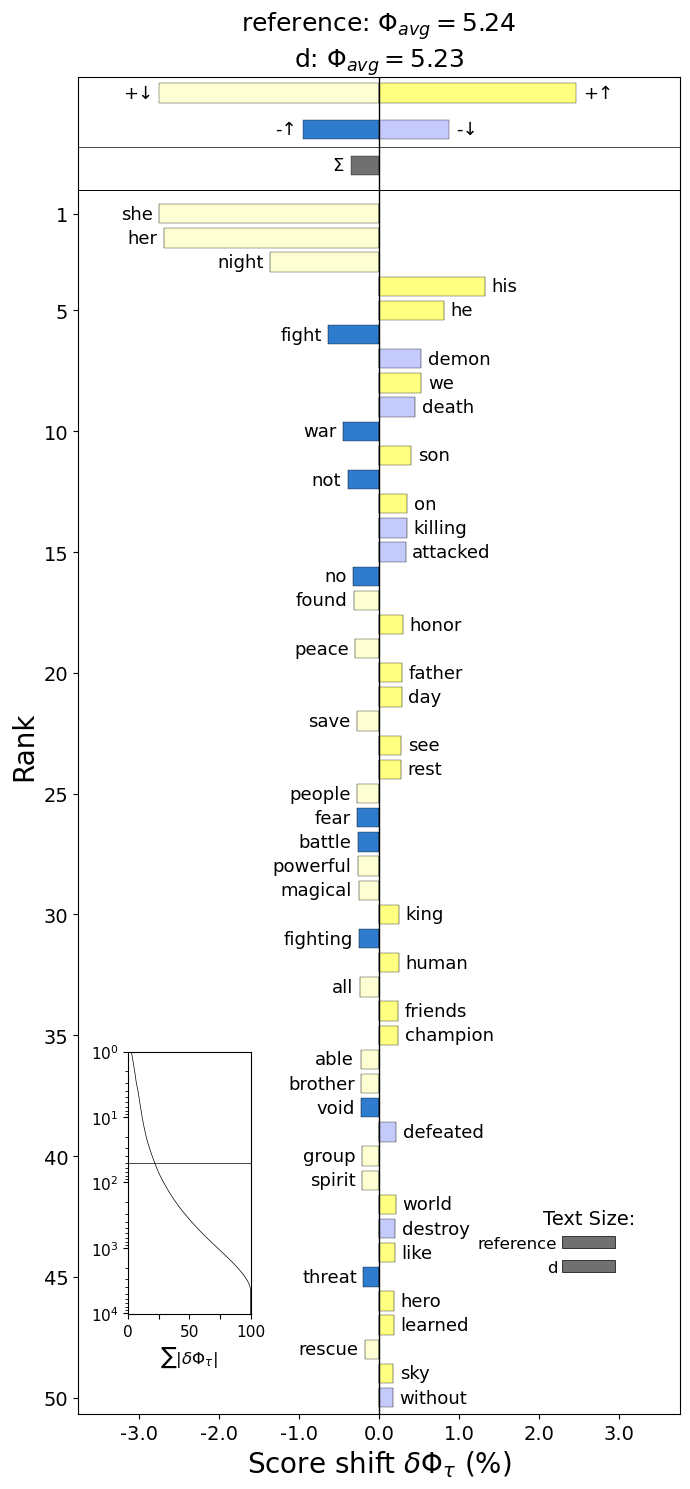

In [72]:
import shifterator as sh
sentiment_shift = sh.WeightedAvgShift(type2freq_1 = p_ref,
                                      type2freq_2 = p,
                                      type2score_1 = dict(df_happy_dict['happiness_average']),
                                      reference_value=5)
sentiment_shift.get_shift_graph(detailed=True,
                             system_names = ['reference', 'd']);